## Deep Learning

> Antonopoulos Ilias (p3352004) <br />
> Ndoja Silva (p3352017) <br />
> MSc Data Science AUEB

## Table of Contents

- [Data Loading](#Data-Loading)
- [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Model Selection](#Model-Selection)
- [Evaluation](#Evaluation)

In [1]:
import gc
import itertools

import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix

from tensorflow.config.experimental import list_physical_devices, set_memory_growth

physical_devices = list_physical_devices("GPU")
set_memory_growth(physical_devices[0], True)

2022-03-08 01:21:04.825219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 01:21:04.856152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 01:21:04.856612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
print(tf.__version__)

2.8.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


### Data Loading

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [7]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [8]:
train_labels = tf.keras.utils.to_categorical(train_labels)

In [9]:
test_labels = tf.keras.utils.to_categorical(test_labels)

In [10]:
test_images.shape

(10000, 28, 28)

This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories,
  along with a test set of 10,000 images.
  
The classes are:
  
| Label | Description |
|:-----:|-------------|
|   0   | T-shirt/top |
|   1   | Trouser     |
|   2   | Pullover    |
|   3   | Dress       |
|   4   | Coat        |
|   5   | Sandal      |
|   6   | Shirt       |
|   7   | Sneaker     |
|   8   | Bag         |
|   9   | Ankle boot  |

In [11]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

### Hyperparameter Tuning

In [12]:
SEED = 123456

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [13]:
def clean_up(model_):
    tf.keras.backend.clear_session()
    del model_
    gc.collect()

In [14]:
hparams = kt.HyperParameters()

hparams.Fixed("optimizer", value="adam")
hparams.Fixed("pooling", value="max")
hparams.Choice("learning_rate", values=[1e-3, 1e-4])

0.001

In [15]:
tuner = kt.Hyperband(
    kt.applications.HyperResNet(input_shape=(28, 28, 1), classes=10),
    objective="val_accuracy",
    hyperparameters=hparams,
    max_epochs=50,  # the maximum number of epochs to train one model
    seed=SEED,
    directory="hparam-tuning",
    project_name="resnet",
)

2022-03-08 01:21:05.390402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 01:21:05.390811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 01:21:05.391177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 01:21:05.919644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 01:21:05.920022: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [16]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
optimizer (Fixed)
{'conditions': [], 'value': 'adam'}
pooling (Fixed)
{'conditions': [], 'value': 'max'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}
version (Choice)
{'default': 'v2', 'conditions': [], 'values': ['v1', 'v2', 'next'], 'ordered': False}
conv3_depth (Choice)
{'default': 4, 'conditions': [], 'values': [4, 8], 'ordered': True}
conv4_depth (Choice)
{'default': 6, 'conditions': [], 'values': [6, 23, 36], 'ordered': True}


In [17]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

In [18]:
tuner.search(
    train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[stop_early]
)

# get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 28 Complete [00h 11m 32s]
val_accuracy: 0.8125

Best val_accuracy So Far: 0.8519999980926514
Total elapsed time: 03h 55m 30s
INFO:tensorflow:Oracle triggered exit


### Model Selection

In [19]:
model = tuner.get_best_models(num_models=1)[0]

model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 34, 34, 1)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 14, 14, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 16, 16, 64)   0           ['conv1_conv[0][0]']             
                                                                                             

                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 7, 7, 64)     16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 7, 7, 64)    256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 7, 7, 64)    0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 4, 4, 128)   0           ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 4, 4, 512)    66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 4, 4, 512)    0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_conv[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_bn (BatchNormal  (None, 2, 2, 256)   1024        ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 2, 2, 256)   0           ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 4, 4, 256)   0           ['conv4_block1_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 2, 2, 256)    589824      ['conv4_block1_2_pad[0][0]']     
          

                                                                                                  
 conv4_block3_out (Add)         (None, 2, 2, 1024)   0           ['conv4_block2_out[0][0]',       
                                                                  'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_block4_preact_bn (BatchN  (None, 2, 2, 1024)  4096        ['conv4_block3_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv4_block4_preact_relu (Acti  (None, 2, 2, 1024)  0           ['conv4_block4_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 1, 1, 256)    589824      ['conv4_block6_2_pad[0][0]']     
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 1, 1, 256)   1024        ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 1, 1, 256)   0           ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 1, 1, 1024)  0           ['conv4_block5_out[0][0]']       
          

                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 1, 1, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 1, 1, 512)    1048576     ['conv5_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 1, 1, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

In [21]:
clean_up(model)

In [22]:
# build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_images, train_labels, epochs=30, validation_split=0.2)

# keep best epoch
val_acc_per_epoch = history.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

Epoch 1/30
1500/1500 [==============================] - 136s 88ms/step - loss: 0.7192 - accuracy: 0.7427 - val_loss: 0.4851 - val_accuracy: 0.8223
Epoch 2/30
1500/1500 [==============================] - 131s 87ms/step - loss: 0.4418 - accuracy: 0.8407 - val_loss: 0.4034 - val_accuracy: 0.8538
Epoch 3/30
1500/1500 [==============================] - 131s 87ms/step - loss: 0.3572 - accuracy: 0.8690 - val_loss: 0.3601 - val_accuracy: 0.8688
Epoch 4/30
1500/1500 [==============================] - 131s 87ms/step - loss: 0.3093 - accuracy: 0.8848 - val_loss: 0.3424 - val_accuracy: 0.8754
Epoch 5/30
1500/1500 [==============================] - 131s 87ms/step - loss: 0.2773 - accuracy: 0.8975 - val_loss: 0.3628 - val_accuracy: 0.8679
Epoch 6/30
1500/1500 [==============================] - 131s 87ms/step - loss: 0.2411 - accuracy: 0.9086 - val_loss: 0.3280 - val_accuracy: 0.8812
Epoch 7/30
1500/1500 [==============================] - 131s 87ms/step - loss: 0.2135 - accuracy: 0.9197 - val_loss: 0

In [23]:
clean_up(model)

In [24]:
hypermodel = tuner.hypermodel.build(best_hps)

# retrain the model
history = hypermodel.fit(
    train_images, train_labels, epochs=best_epoch, validation_split=0.2
)

Epoch 1/30
1500/1500 [==============================] - 135s 87ms/step - loss: 0.7165 - accuracy: 0.7435 - val_loss: 0.5116 - val_accuracy: 0.8114
Epoch 2/30
1500/1500 [==============================] - 130s 87ms/step - loss: 0.4385 - accuracy: 0.8406 - val_loss: 0.4029 - val_accuracy: 0.8529
Epoch 3/30
1500/1500 [==============================] - 130s 87ms/step - loss: 0.3602 - accuracy: 0.8667 - val_loss: 0.3780 - val_accuracy: 0.8577
Epoch 4/30
1500/1500 [==============================] - 130s 87ms/step - loss: 0.3098 - accuracy: 0.8849 - val_loss: 0.3392 - val_accuracy: 0.8766
Epoch 5/30
1500/1500 [==============================] - 130s 87ms/step - loss: 0.2773 - accuracy: 0.8974 - val_loss: 0.3602 - val_accuracy: 0.8668
Epoch 6/30
1500/1500 [==============================] - 130s 87ms/step - loss: 0.2401 - accuracy: 0.9104 - val_loss: 0.3324 - val_accuracy: 0.8814
Epoch 7/30
1500/1500 [==============================] - 130s 87ms/step - loss: 0.2173 - accuracy: 0.9184 - val_loss: 0

### Evaluation

In [25]:
eval_result = hypermodel.evaluate(test_images, test_labels, verbose=3)
print("[test loss, test accuracy]:", eval_result)

[test loss, test accuracy]: [0.45618003606796265, 0.894599974155426]


2022-03-08 07:27:27.833667: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [26]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use("dark_background")
    plt.rcParams["figure.figsize"] = [15, 8]
    plt.rcParams["font.size"] = 16
    plt.clf()
    for label in hs:
        plt.plot(
            hs[label].history[metric],
            label="{0:s} train {1:s}".format(label, metric),
            linewidth=2,
        )
        plt.plot(
            hs[label].history["val_{0:s}".format(metric)],
            label="{0:s} validation {1:s}".format(label, metric),
            linewidth=2,
        )
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks[0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel("Epochs")
    plt.ylabel("Loss" if metric == "loss" else "Accuracy")
    plt.legend()
    plt.show()

Train Loss          : 0.03711
Validation Loss     : 0.44671
Test Loss           : 0.45618
-------------------
Train Accuracy      : 0.98671
Validation Accuracy : 0.89333
Test Accuracy       : 0.89460



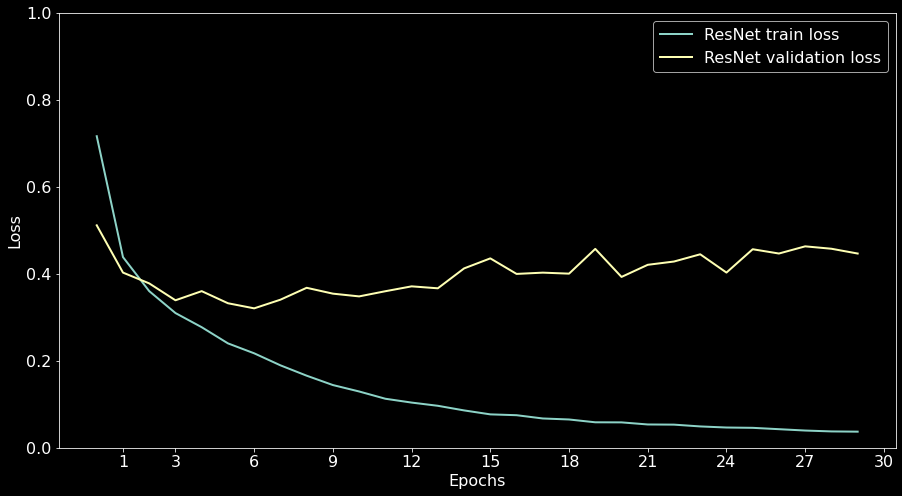

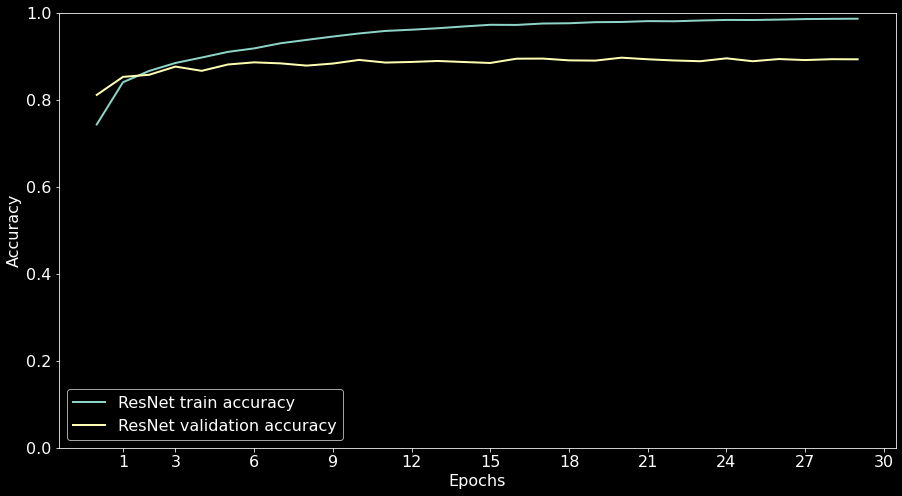

In [27]:
print("Train Loss          : {0:.5f}".format(history.history["loss"][-1]))
print("Validation Loss     : {0:.5f}".format(history.history["val_loss"][-1]))
print("Test Loss           : {0:.5f}".format(eval_result[0]))
print("-------------------")
print("Train Accuracy      : {0:.5f}".format(history.history["accuracy"][-1]))
print("Validation Accuracy : {0:.5f}".format(history.history["val_accuracy"][-1]))
print("Test Accuracy       : {0:.5f}".format(eval_result[1]))

# Plot train and validation error per epoch.
plot_history(hs={"ResNet": history}, epochs=best_epoch, metric="loss")
plot_history(hs={"ResNet": history}, epochs=best_epoch, metric="accuracy")

In [28]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.PuBuGn
):

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = [11, 9]
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

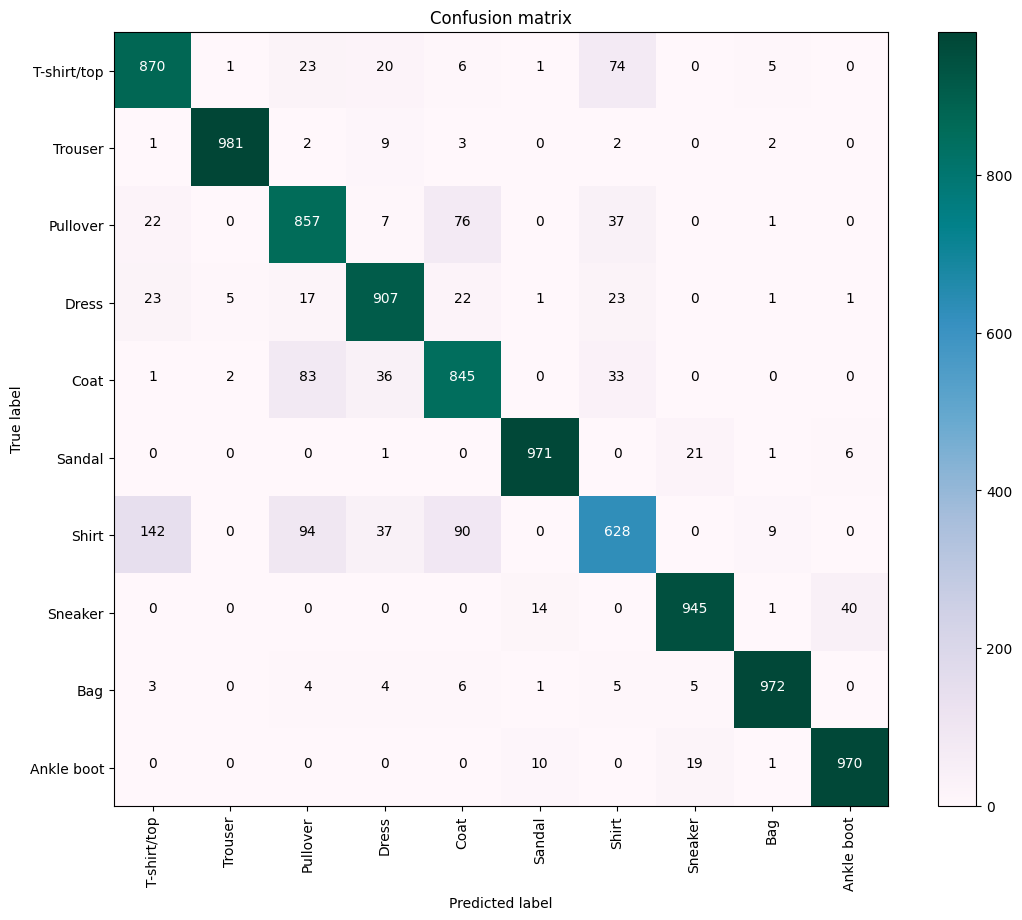

In [30]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Predict the values from the validation dataset
Y_pred = hypermodel.predict(test_images)

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(
    confusion_mtx,
    classes=class_names,
)

In [31]:
incorrect = []
for i in range(len(test_labels)):
    if not Y_pred_classes[i] == test_labels[i]:
        incorrect.append(i)
    if len(incorrect) == 4:
        break

Text(0.5, 1.0, 'Predicted Label : Coat\nActual Label : Shirt')

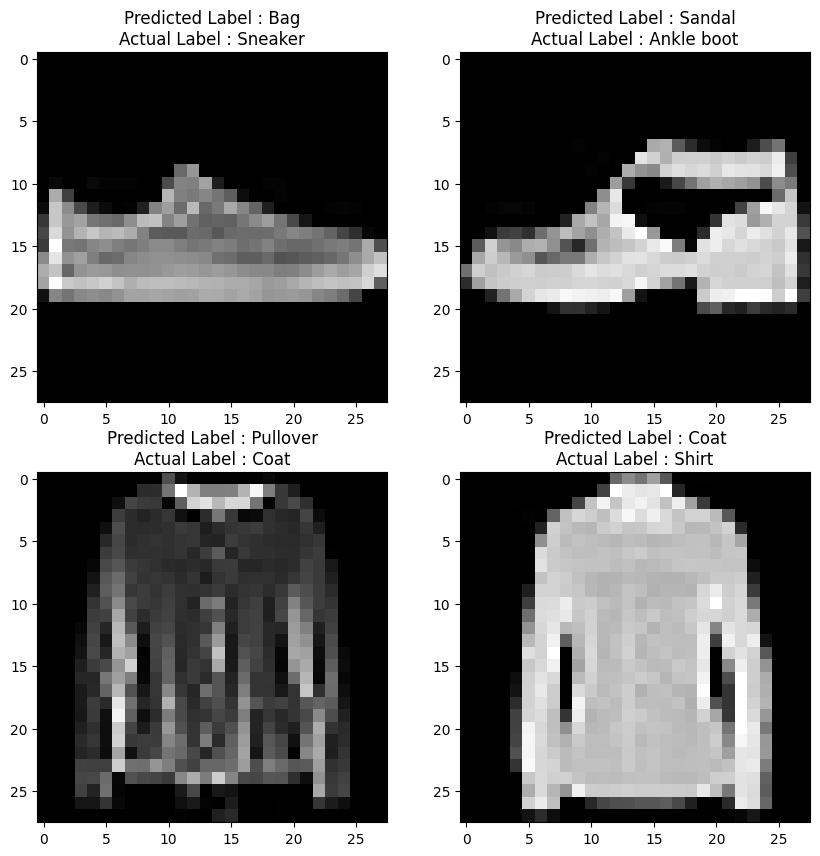

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
fig.set_size_inches(10, 10)
ax[0, 0].imshow(test_images[incorrect[0]].reshape(28, 28), cmap="gray")

ax[0, 0].set_title(
    "Predicted Label : "
    + class_names[Y_pred_classes[incorrect[0]]]
    + "\n"
    + "Actual Label : "
    + class_names[test_labels[incorrect[0]]]
)
ax[0, 1].imshow(test_images[incorrect[1]].reshape(28, 28), cmap="gray")
ax[0, 1].set_title(
    "Predicted Label : "
    + class_names[Y_pred_classes[incorrect[1]]]
    + "\n"
    + "Actual Label : "
    + class_names[test_labels[incorrect[1]]]
)
ax[1, 0].imshow(test_images[incorrect[2]].reshape(28, 28), cmap="gray")
ax[1, 0].set_title(
    "Predicted Label : "
    + class_names[Y_pred_classes[incorrect[2]]]
    + "\n"
    + "Actual Label : "
    + class_names[test_labels[incorrect[2]]]
)
ax[1, 1].imshow(test_images[incorrect[3]].reshape(28, 28), cmap="gray")
ax[1, 1].set_title(
    "Predicted Label : "
    + class_names[Y_pred_classes[incorrect[3]]]
    + "\n"
    + "Actual Label : "
    + class_names[test_labels[incorrect[3]]]
)